In [2]:
# Loading packages
import os
import csv
import numpy as np
from numpy import quantile, random, where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import collections
from sklearn import preprocessing
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from scipy.stats import kurtosis
from scipy.stats import skew
import missingno as msno
from sklearn import svm
from imblearn.over_sampling import SMOTE

In [3]:
# Load the DataFrame from the pickle file
df = pd.read_pickle('documents_topics.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57790 entries, 0 to 57789
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      57790 non-null  object 
 1   text                          57790 non-null  object 
 2   created_at                    57790 non-null  object 
 3   campaign_week                 57790 non-null  int64  
 4   process_text_check            57790 non-null  object 
 5   name                          57790 non-null  object 
 6   handle                        57790 non-null  object 
 7   party                         57790 non-null  object 
 8   state_code                    57790 non-null  object 
 9   state_name                    57790 non-null  object 
 10  result_pctg                   57790 non-null  float64
 11  result_votes                  57790 non-null  int64  
 12  position                      57790 non-null  int64  
 13  t

## Test for RQ1

In [4]:
#transform topics to know if there were city reference in the tweet or not

columns_to_replicate = [
    'Campaign Event', 'Social Protection', 'General Discussion', 'Abortion',
    'Homeland Security', 'Candidate Denigration', 'Vote Instigation',
    'Campaign Contribution', 'Economy Policies'
]

def create_new_columns(row):
    new_data = {}
    check_city_filtered_na = pd.isna(row['check_city_filtered'])

    # If 'check_city_filtered' contains an array, use any() function, else use the value directly
    if isinstance(check_city_filtered_na, np.ndarray):
        has_missing_values = check_city_filtered_na.any()
    else:
        has_missing_values = check_city_filtered_na

    for col in columns_to_replicate:
        if has_missing_values:
            new_data[col + '_withoutlocaltweet'] = row[col]
        else:
            new_data[col + '_withlocaltweet'] = row[col]
    return pd.Series(new_data)

# Apply the function to the DataFrame and concatenate the resulting columns
new_columns = df.apply(create_new_columns, axis=1)

# Fill NaN values with 0 in the new_columns DataFrame
new_columns = new_columns.fillna(0)

df_base = pd.concat([df, new_columns], axis=1)
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57790 entries, 0 to 57789
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tweet_id                                 57790 non-null  object 
 1   text                                     57790 non-null  object 
 2   created_at                               57790 non-null  object 
 3   campaign_week                            57790 non-null  int64  
 4   process_text_check                       57790 non-null  object 
 5   name                                     57790 non-null  object 
 6   handle                                   57790 non-null  object 
 7   party                                    57790 non-null  object 
 8   state_code                               57790 non-null  object 
 9   state_name                               57790 non-null  object 
 10  result_pctg                              57790

In [5]:
# Columns you want to include in the new dataset
selected_columns = ['name','party','position','Abortion_withlocaltweet','Abortion_withoutlocaltweet','Campaign Contribution_withlocaltweet','Campaign Contribution_withoutlocaltweet',
                    'Campaign Event_withlocaltweet','Campaign Event_withoutlocaltweet','Candidate Denigration_withlocaltweet','Candidate Denigration_withoutlocaltweet','Economy Policies_withlocaltweet','Economy Policies_withoutlocaltweet',
                    'General Discussion_withlocaltweet','General Discussion_withoutlocaltweet','Homeland Security_withlocaltweet',
                    'Homeland Security_withoutlocaltweet','Social Protection_withlocaltweet','Social Protection_withoutlocaltweet',
                    'Vote Instigation_withlocaltweet','Vote Instigation_withoutlocaltweet']

# Create a new DataFrame with the selected columns
df_wip = df_base[selected_columns]
df_wip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57790 entries, 0 to 57789
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   name                                     57790 non-null  object 
 1   party                                    57790 non-null  object 
 2   position                                 57790 non-null  int64  
 3   Abortion_withlocaltweet                  57790 non-null  float64
 4   Abortion_withoutlocaltweet               57790 non-null  float64
 5   Campaign Contribution_withlocaltweet     57790 non-null  float64
 6   Campaign Contribution_withoutlocaltweet  57790 non-null  float64
 7   Campaign Event_withlocaltweet            57790 non-null  float64
 8   Campaign Event_withoutlocaltweet         57790 non-null  float64
 9   Candidate Denigration_withlocaltweet     57790 non-null  float64
 10  Candidate Denigration_withoutlocaltweet  57790

## Let's try predicting winning or not

In [6]:
#create a dataframe with the values for the algorithms

agg_dict = {
    #aggregate the numerical values
    'Abortion_withlocaltweet': 'mean',
    'Abortion_withoutlocaltweet': 'mean',
    'Campaign Contribution_withlocaltweet': 'mean',
    'Campaign Contribution_withoutlocaltweet': 'mean',
    'Campaign Event_withlocaltweet': 'mean',
    'Campaign Event_withoutlocaltweet': 'mean',
    'Candidate Denigration_withlocaltweet': 'mean',
    'Candidate Denigration_withoutlocaltweet': 'mean',
    'Economy Policies_withlocaltweet': 'mean',
    'Economy Policies_withoutlocaltweet': 'mean',
    'General Discussion_withlocaltweet': 'mean',
    'General Discussion_withoutlocaltweet': 'mean',
    'Homeland Security_withlocaltweet': 'mean',
    'Homeland Security_withoutlocaltweet': 'mean',
    'Social Protection_withlocaltweet': 'mean',
    'Social Protection_withoutlocaltweet': 'mean',
    'Vote Instigation_withlocaltweet': 'mean',
    'Vote Instigation_withoutlocaltweet': 'mean',
    #now the categorical values
    'party':'last',
    'position':'last'
}


#create the new dataframe
df_wip = df_wip.groupby(['name']).agg(agg_dict).reset_index()

In [7]:
df_wip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   name                                     79 non-null     object 
 1   Abortion_withlocaltweet                  79 non-null     float64
 2   Abortion_withoutlocaltweet               79 non-null     float64
 3   Campaign Contribution_withlocaltweet     79 non-null     float64
 4   Campaign Contribution_withoutlocaltweet  79 non-null     float64
 5   Campaign Event_withlocaltweet            79 non-null     float64
 6   Campaign Event_withoutlocaltweet         79 non-null     float64
 7   Candidate Denigration_withlocaltweet     79 non-null     float64
 8   Candidate Denigration_withoutlocaltweet  79 non-null     float64
 9   Economy Policies_withlocaltweet          79 non-null     float64
 10  Economy Policies_withoutlocaltweet       79 non-null

In [8]:
#transform position into winning or not
df_wip['is_winner'] = (df_wip['position'] == 1).astype(int)

#remove name and position columns
df_wip = df_wip.drop(columns=['name','position'], axis=1)
# Encode categorical values into dummy variables
cols = ['party']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
ds_work = ce_one_hot.fit_transform(df_wip)

In [9]:
#normalization of the data to make model with better accuracy
ds_work = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(ds_work.values), columns=ds_work.columns,index=ds_work.index)
ds_work.describe()

,Abortion_withlocaltweet,Abortion_withoutlocaltweet,Campaign Contribution_withlocaltweet,Campaign Contribution_withoutlocaltweet,Campaign Event_withlocaltweet,Campaign Event_withoutlocaltweet,Candidate Denigration_withlocaltweet,Candidate Denigration_withoutlocaltweet,Economy Policies_withlocaltweet,Economy Policies_withoutlocaltweet,...,Homeland Security_withoutlocaltweet,Social Protection_withlocaltweet,Social Protection_withoutlocaltweet,Vote Instigation_withlocaltweet,Vote Instigation_withoutlocaltweet,party_Rep,party_Dem,party_Lib,party_Indpt,is_winner
count,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,...,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
mean,0.223379,0.328696,0.121294,0.203639,0.329205,0.357522,0.154923,0.349174,0.180557,0.280083,...,0.232496,0.312323,0.318010,0.334670,0.243688,0.443038,0.417722,0.113924,0.025316,0.430380
std,0.163644,0.190692,0.132847,0.184078,0.210772,0.208714,0.144303,0.234181,0.210120,0.249743,...,0.174119,0.225976,0.234405,0.218617,0.177900,0.499919,0.496335,0.319749,0.158088,0.498293
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.118809,0.201083,0.052310,0.103991,0.197570,0.220371,0.072023,0.177146,0.046691,0.087300,...,0.113403,0.170531,0.138322,0.202882,0.127711,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.197744,0.294744,0.089315,0.156488,0.319963,0.314356,0.116828,0.303888,0.087769,0.181455,...,0.180746,0.233330,0.288427,0.288000,0.219074,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.264006,0.425707,0.137900,0.235425,0.421236,0.479142,0.199893,0.456053,0.235860,0.405702,...,0.315999,0.458644,0.430415,0.410080,0.323979,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## *Modelling*
### Logistic Regression

In [10]:
# Create the Target
y = ds_work['is_winner']

In [11]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(ds_work, y, test_size=0.25, stratify=y, random_state=123)

In [12]:
# Remove the Target from the training
X_train = X_train.drop(['is_winner'],axis=1)
X_test = X_test.drop(['is_winner'],axis=1)

In [13]:
# Hyper Tuning Logistic Regression
grid_param = [{'solver':['liblinear', 'newton-cg','lbfgs'],  # <-- For reduction of time, we put liblinear because it is better for smaller datasets
               'verbose':[0,1],
               'multi_class':['auto','ovr','multinomial'],
               'max_iter':[100,300,500,700,900,1000,2000],
               'random_state':[123]}]
reg = LogisticRegression()
grid = GridSearchCV(reg, grid_param, cv=20)
grid.fit(X_train, y_train)
print("Grid search best parameters: {}".format(grid.best_params_))

[LibLinear]iter  1 act 1.033e+01 pre 9.741e+00 delta 2.762e+00 f 3.882e+01 |g| 9.689e+00 CG   4
iter  2 act 2.352e-01 pre 2.251e-01 delta 2.762e+00 f 2.849e+01 |g| 1.646e+00 CG   4
iter  3 act 1.756e-03 pre 1.751e-03 delta 2.762e+00 f 2.825e+01 |g| 1.322e-01 CG   4
iter  4 act 5.500e-06 pre 5.501e-06 delta 2.762e+00 f 2.825e+01 |g| 4.622e-03 CG   4
[LibLinear]iter  1 act 9.281e+00 pre 8.791e+00 delta 2.672e+00 f 3.882e+01 |g| 9.452e+00 CG   4
iter  2 act 1.645e-01 pre 1.588e-01 delta 2.672e+00 f 2.954e+01 |g| 1.451e+00 CG   3
iter  3 act 4.593e-03 pre 4.587e-03 delta 2.672e+00 f 2.937e+01 |g| 1.476e-01 CG   4
iter  4 act 1.990e-05 pre 1.990e-05 delta 2.672e+00 f 2.937e+01 |g| 7.994e-03 CG   4
iter  5 act 2.338e-08 pre 2.338e-08 delta 2.672e+00 f 2.937e+01 |g| 5.288e-04 CG   3
[LibLinear]iter  1 act 1.082e+01 pre 1.020e+01 delta 2.802e+00 f 3.882e+01 |g| 1.009e+01 CG   4
iter  2 act 2.515e-01 pre 2.406e-01 delta 2.802e+00 f 2.800e+01 |g| 1.706e+00 CG   4
iter  3 act 1.961e-03 pre 1.955e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_job

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_job

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     23     26      1     0     0   8.627D-05   2.490D+01
  F =   24.901140296199955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialB

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     23     26      1     0     0   8.627D-05   2.490D+01
  F =   24.901140296199955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 Thi

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_job

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     23     26      1     0     0   8.627D-05   2.490D+01
  F =   24.901140296199955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialB

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     23     26      1     0     0   8.627D-05   2.490D+01
  F =   24.901140296199955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     23     26      1     0     0   8.627D-05   2.490D+01
  F =   24.901140296199955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_job

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     23     26      1     0     0   8.627D-05   2.490D+01
  F =   24.901140296199955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialB

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s f

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     19     22      1     0     0   1.122D-04   2.797D+01
  F =   27.974386517164078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88162D+01    |proj g|=  4.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   46     23     26      1     0     0   8.627D-05   2.490D+01
  F =   24.901140296199955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           46     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 Thi

In [14]:
# Create object and train the model
classModel = LogisticRegression(**grid.best_params_)
classModel.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', random_state=123,
                   solver='newton-cg')

In [15]:
#to create dataframe with metrics and insert the values in a already existing dataframe in order to compare all the models results
resultsDF_compare = pd.DataFrame()
resultsDF_compare['Measure'] = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']

# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest, modelName, dataFrameToAssign=resultsDF_compare):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
    train_results = ["{0:.2}".format(metricsObj.accuracy_score(yTrain, yPredTrain)),
                     "{0:.2}".format(metricsObj.precision_score(yTrain, yPredTrain)),
                     "{0:.2}".format(metricsObj.recall_score(yTrain, yPredTrain)),
                     "{0:.2}".format(metricsObj.f1_score(yTrain, yPredTrain)),
                     "{0:.2}".format(metricsObj.roc_auc_score(yTrain, yPredTrain))
                     ]
    test_results = ["{0:.2}".format(metricsObj.accuracy_score(yTest, yPredTest)),
                    "{0:.2}".format(metricsObj.precision_score(yTest, yPredTest)),
                    "{0:.2}".format(metricsObj.recall_score(yTest, yPredTest)),
                    "{0:.2}".format(metricsObj.f1_score(yTest, yPredTest)),
                    "{0:.2}".format(metricsObj.roc_auc_score(yTest, yPredTest))
                    ]
    resultsDF = pd.DataFrame({"Measure": measures_list, "Train_{0}".format(modelName): train_results, "Test_{0}".format(modelName):test_results})

    dataFrameToAssign["Train_{0}".format(modelName)] = train_results
    dataFrameToAssign["Test_{0}".format(modelName)] = test_results
    return(resultsDF)

In [16]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train)
y_pred_test = classModel.predict(X_test)

In [17]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

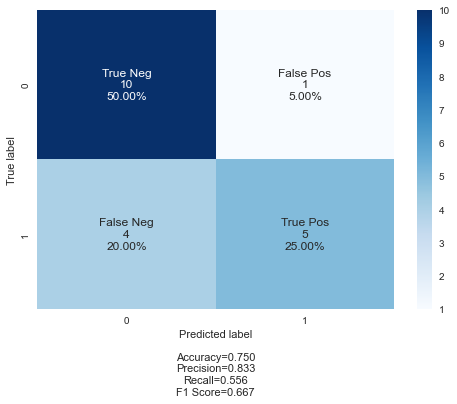

In [18]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [19]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test,"LR")
resultsDF

,Measure,Train_LR,Test_LR
0,ACCURACY,0.86,0.75
1,PRECISION,0.81,0.83
2,RECALL,0.88,0.56
3,F1 SCORE,0.85,0.67
4,AUC,0.87,0.73


Counter({0.0: 34, 1.0: 25})


<AxesSubplot:xlabel='y', ylabel='count'>

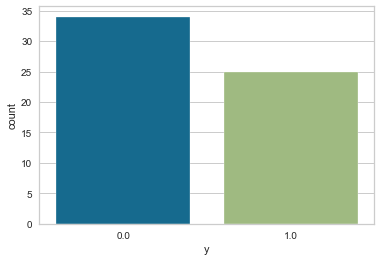

In [20]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train}), ax=ax)

Counter({0.0: 34, 1.0: 34})


<AxesSubplot:xlabel='y', ylabel='count'>

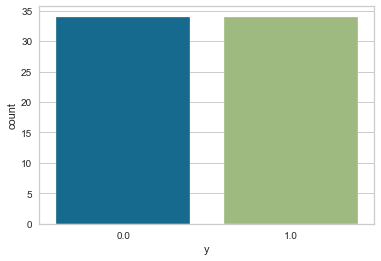

In [21]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train2, y_train2 = sm.fit_resample(X_train, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="y", data=pd.DataFrame(data={'y':y_train2}), ax=ax)

In [22]:
# Train de model
classModel.fit(X_train2, y_train2)

# Predict values
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train2)
y_pred_test = classModel.predict(X_test)

# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test,"LR")
resultsDF

,Measure,Train_LR,Test_LR
0,ACCURACY,0.87,0.8
1,PRECISION,0.79,0.78
2,RECALL,1.0,0.78
3,F1 SCORE,0.88,0.78
4,AUC,0.87,0.8


/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


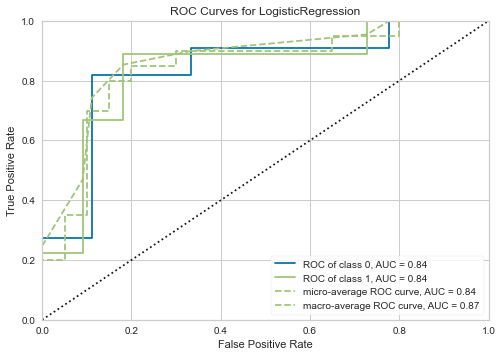

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [23]:
# ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train2, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

### Support Vector Machine

In [24]:
# Create the Target
y = ds_work['is_winner']

In [25]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(ds_work, y, test_size=0.25, stratify=y, random_state=123)

In [26]:
# Remove the Target from the training
X_train = X_train.drop(['is_winner'],axis=1)
X_test = X_test.drop(['is_winner'],axis=1)

In [27]:
# Dataframe for scaling
tempDF = ds_work.copy(deep=True)
tempDF.drop(columns='is_winner', inplace=True)

# Normalize training/test data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Counter({0.0: 34, 1.0: 25})


<AxesSubplot:xlabel='is_winner', ylabel='count'>

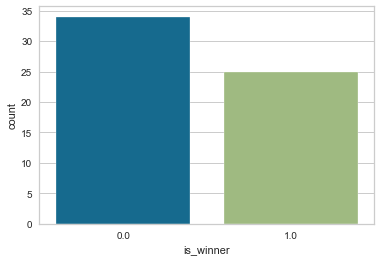

In [28]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train}), ax=ax)

Counter({0.0: 34, 1.0: 34})


<AxesSubplot:xlabel='is_winner', ylabel='count'>

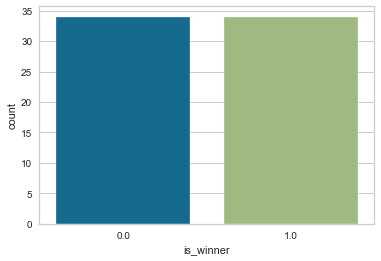

In [29]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_scaled2, y_train2 = sm.fit_resample(X_train_scaled, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train2}), ax=ax)

In [30]:
# Create object and train the model
classModel = svm.SVC(gamma='scale', random_state=123, probability=True)
classModel.fit(X_train_scaled2, y_train2)

SVC(probability=True, random_state=123)

In [31]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train_scaled2)
y_pred_test = classModel.predict(X_test_scaled)

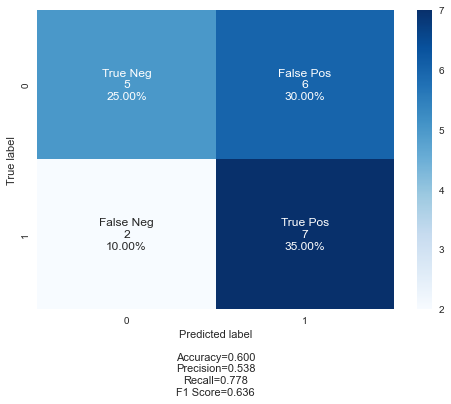

In [32]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [33]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test,"SVM")
resultsDF

,Measure,Train_SVM,Test_SVM
0,ACCURACY,0.87,0.6
1,PRECISION,0.8,0.54
2,RECALL,0.97,0.78
3,F1 SCORE,0.88,0.64
4,AUC,0.87,0.62


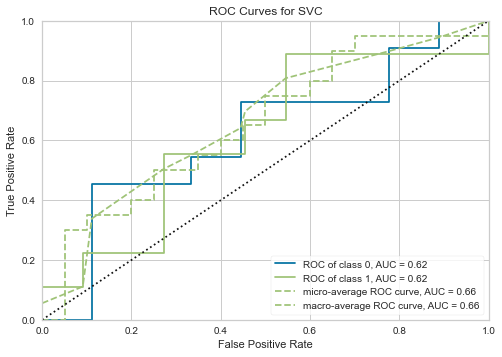

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [34]:
# ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train_scaled2, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

### 6.3 K. Nearest Neighbor

In [35]:
# Create the Target
y = ds_work['is_winner']

In [36]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(ds_work, y, test_size=0.25, stratify=y, random_state=123)

In [37]:
# Remove the Target from the training
X_train = X_train.drop(['is_winner'],1)
X_test = X_test.drop(['is_winner'],1)

/var/folders/hw/0nn4k6y96p3grs2cw32myzzr0000gn/T/ipykernel_32502/776441785.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop(['is_winner'],1)
/var/folders/hw/0nn4k6y96p3grs2cw32myzzr0000gn/T/ipykernel_32502/776441785.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop(['is_winner'],1)


In [38]:
# Dataframe for scaling
tempDF = ds_work.copy(deep=True)
tempDF.drop(columns='is_winner', inplace=True)

# Normalize training/test data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Counter({0.0: 34, 1.0: 25})


<AxesSubplot:xlabel='is_winner', ylabel='count'>

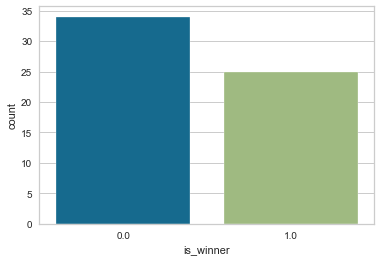

In [39]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train}), ax=ax)

Counter({0.0: 34, 1.0: 34})


<AxesSubplot:xlabel='is_winner', ylabel='count'>

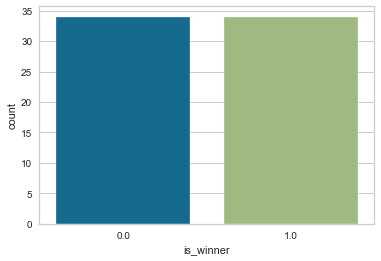

In [40]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_scaled2, y_train2 = sm.fit_resample(X_train_scaled, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train2}), ax=ax)

In [41]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]
weights = ['uniform','distance']
algorithm = ['auto','ball_tree','kd_tree','brute']
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p,weights=weights,algorithm=algorithm)

#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn, hyperparameters, cv=10)

#Fit the Model
classModel= clf.fit(X_train_scaled2, y_train2)

#Print The value of best Hyperparameters
print('Best leaf_size:', classModel.best_estimator_.get_params()['leaf_size'])
print('Best p:', classModel.best_estimator_.get_params()['p'])
print('Best n_neighbors:', classModel.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', classModel.best_estimator_.get_params()['weights'])
print('Best algorithm:', classModel.best_estimator_.get_params()['algorithm'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 3
Best weights: distance
Best algorithm: auto


In [42]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train_scaled2)
y_pred_test = classModel.predict(X_test_scaled)

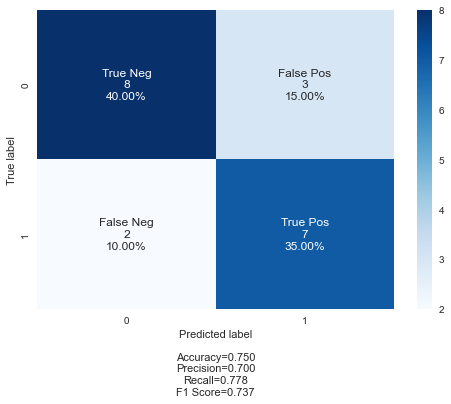

In [43]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [44]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test,"KNN")
resultsDF

,Measure,Train_KNN,Test_KNN
0,ACCURACY,1.0,0.75
1,PRECISION,1.0,0.7
2,RECALL,1.0,0.78
3,F1 SCORE,1.0,0.74
4,AUC,1.0,0.75


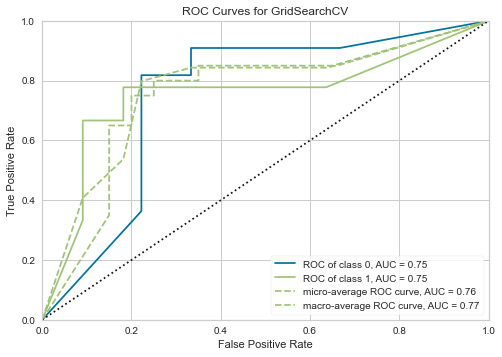

<AxesSubplot:title={'center':'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [45]:
# ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train_scaled2, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

### 6.4 Neural Network


In [46]:
# Create the Target
y = ds_work['is_winner']

In [47]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(ds_work, y, test_size=0.25, stratify=y, random_state=123)

In [48]:
# Remove the Target from the training
X_train = X_train.drop(['is_winner'],1)
X_test = X_test.drop(['is_winner'],1)

/var/folders/hw/0nn4k6y96p3grs2cw32myzzr0000gn/T/ipykernel_32502/776441785.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop(['is_winner'],1)
/var/folders/hw/0nn4k6y96p3grs2cw32myzzr0000gn/T/ipykernel_32502/776441785.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop(['is_winner'],1)


In [49]:
# Dataframe for scaling
tempDF = ds_work.copy(deep=True)
tempDF.drop(columns='is_winner', inplace=True)

# Normalize training/test data
scaler = MinMaxScaler(feature_range=(0, 1))
tempDF_scaled = scaler.fit_transform(tempDF)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Counter({0.0: 34, 1.0: 25})
0.0    0.576271
1.0    0.423729
Name: is_winner, dtype: float64


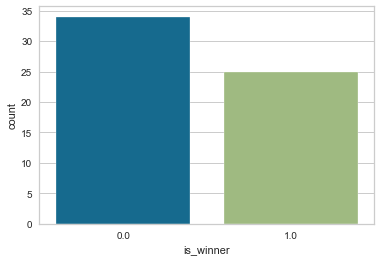

In [50]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train}), ax=ax)
print(y_train.value_counts(normalize=True))

Counter({0.0: 34, 1.0: 34})


<AxesSubplot:xlabel='is_winner', ylabel='count'>

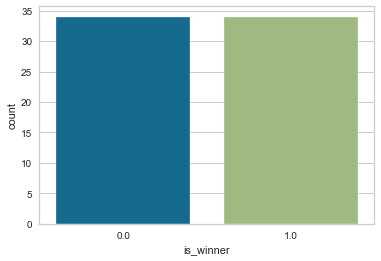

In [51]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train_scaled2, y_train2 = sm.fit_resample(X_train_scaled, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train2}), ax=ax)

In [52]:
grid_param = [{'hidden_layer_sizes':[20,40,60],
               'activation':['identity','logistic','tanh','relu'],
               'solver':['lbfgs','sgd','adam'],
               'alpha':[0.0001, 0.002, 0.05],
               'batch_size':['auto'],
               'learning_rate':['constant'],
               'learning_rate_init':[0.001, 0.002],
               'max_iter':[100,300,500,600,700,800,900,1000,2000],
               'random_state':[123]}]
reg = MLPClassifier()
grid = GridSearchCV(reg, grid_param, cv=5)
grid.fit(X_train, y_train)
print("Grid search best parameters: {}".format(grid.best_params_))

/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: Converg

Grid search best parameters: {'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'hidden_layer_sizes': 60, 'learning_rate': 'constant', 'learning_rate_init': 0.002, 'max_iter': 100, 'random_state': 123, 'solver': 'adam'}


/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
# Create object and train the model
classModel = MLPClassifier(**grid.best_params_)
classModel.fit(X_train_scaled2, y_train2)

/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='identity', hidden_layer_sizes=60,
              learning_rate_init=0.002, max_iter=100, random_state=123)

In [54]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train_scaled2)
y_pred_test = classModel.predict(X_test_scaled)

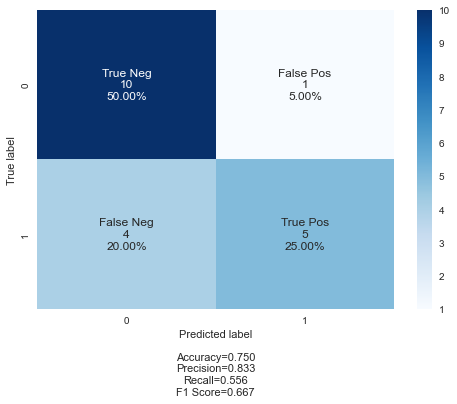

In [55]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [56]:
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test,"NN")
resultsDF

,Measure,Train_NN,Test_NN
0,ACCURACY,0.9,0.75
1,PRECISION,0.85,0.83
2,RECALL,0.97,0.56
3,F1 SCORE,0.9,0.67
4,AUC,0.9,0.73


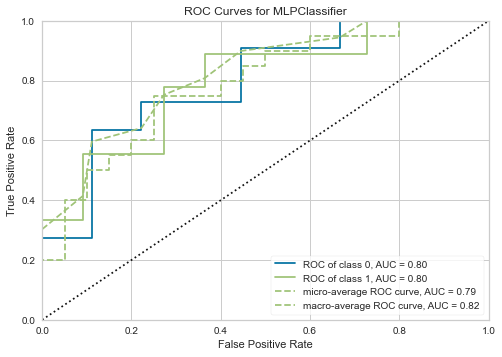

<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [57]:
# ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train_scaled2, y_train)
visualizer.score(X_test_scaled, y_test)
visualizer.show()

### 6.5 Naive Bayes

In [58]:
# Create the Target
y = ds_work['is_winner']

In [59]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(ds_work, y, test_size=0.25, stratify=y, random_state=123)

In [60]:
# Remove the Target from the training
X_train = X_train.drop(['is_winner'],1)
X_test = X_test.drop(['is_winner'],1)

/var/folders/hw/0nn4k6y96p3grs2cw32myzzr0000gn/T/ipykernel_32502/776441785.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop(['is_winner'],1)
/var/folders/hw/0nn4k6y96p3grs2cw32myzzr0000gn/T/ipykernel_32502/776441785.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop(['is_winner'],1)


Counter({0.0: 34, 1.0: 25})
0.0    0.576271
1.0    0.423729
Name: is_winner, dtype: float64


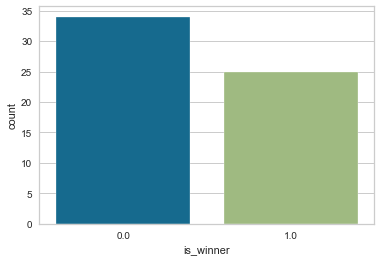

In [61]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train}), ax=ax)
print(y_train.value_counts(normalize=True))

Counter({0.0: 34, 1.0: 34})


<AxesSubplot:xlabel='Exited', ylabel='count'>

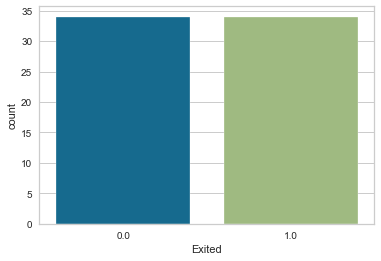

In [62]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train2, y_train2 = sm.fit_resample(X_train, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Exited", data=pd.DataFrame(data={'Exited':y_train2}), ax=ax)

In [63]:
# Create object and train the model
classModel = GaussianNB()
classModel.fit(X_train2, y_train2)

GaussianNB()

In [64]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train2)
y_pred_test = classModel.predict(X_test)

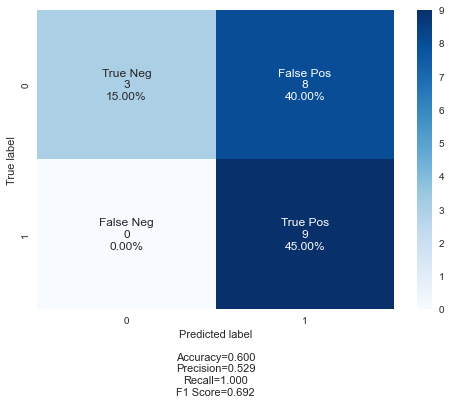

In [65]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [66]:
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test,"NB")
resultsDF

,Measure,Train_NB,Test_NB
0,ACCURACY,0.69,0.6
1,PRECISION,0.62,0.53
2,RECALL,1.0,1.0
3,F1 SCORE,0.76,0.69
4,AUC,0.69,0.64


/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


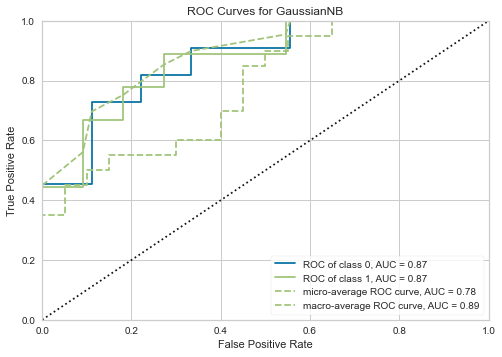

<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [67]:
# ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train2, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

### 6.6 Decision Tree

In [68]:
# Create the Target
y = ds_work['is_winner']

In [69]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(ds_work, y, test_size=0.25, stratify=y, random_state=123)

In [70]:
# Remove the Target from the training
X_train = X_train.drop(['is_winner'],1)
X_test = X_test.drop(['is_winner'],1)

/var/folders/hw/0nn4k6y96p3grs2cw32myzzr0000gn/T/ipykernel_32502/776441785.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop(['is_winner'],1)
/var/folders/hw/0nn4k6y96p3grs2cw32myzzr0000gn/T/ipykernel_32502/776441785.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop(['is_winner'],1)


Counter({0.0: 34, 1.0: 25})
0.0    0.576271
1.0    0.423729
Name: is_winner, dtype: float64


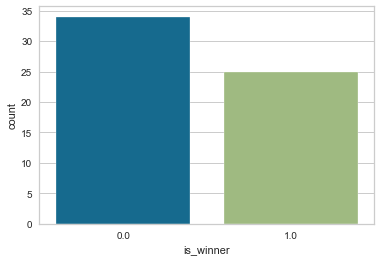

In [71]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train}), ax=ax)
print(y_train.value_counts(normalize=True))

Counter({0.0: 34, 1.0: 34})


<AxesSubplot:xlabel='is_winner', ylabel='count'>

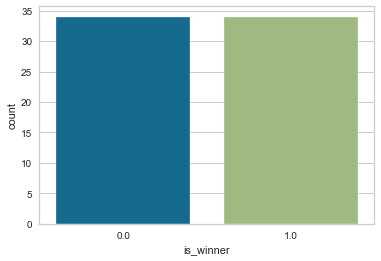

In [72]:
# Applyting SMOTE to generare new instances (oversampling)
sm = SMOTE(random_state=123, sampling_strategy=1.0)
X_train2, y_train2 = sm.fit_resample(X_train, y_train)

# Display target balance in the training dataset
print(collections.Counter(y_train2))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="is_winner", data=pd.DataFrame(data={'is_winner':y_train2}), ax=ax)

In [73]:
# Create object and train the model
classModel = tree.DecisionTreeClassifier(max_depth=4, random_state=123)
classModel.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=4, random_state=123)

In [74]:
grid_param = [{'criterion':['gini','entropy'],
               'max_depth':[2,3,4,5],
               'min_samples_split':[1, 2, 3,4],
               'min_samples_leaf':[1,2,3],
               'max_leaf_nodes':[1,2,3,4,5],
               'random_state':[123]}]
reg = tree.DecisionTreeClassifier()
grid = GridSearchCV(reg, grid_param, cv=5)
grid.fit(X_train, y_train)
print("Grid search best parameters: {}".format(grid.best_params_))

Grid search best parameters: {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 123}


/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
960 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 969, in fit
    super().fit(
  File "/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 265, in fit
   

In [75]:
# Create object and train the model
classModel = tree.DecisionTreeClassifier(**grid.best_params_)
classModel.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=2, max_leaf_nodes=2, random_state=123)

In [76]:
# predict y for X_train and X_test
y_pred_train = classModel.predict(X_train2)
y_pred_test = classModel.predict(X_test)

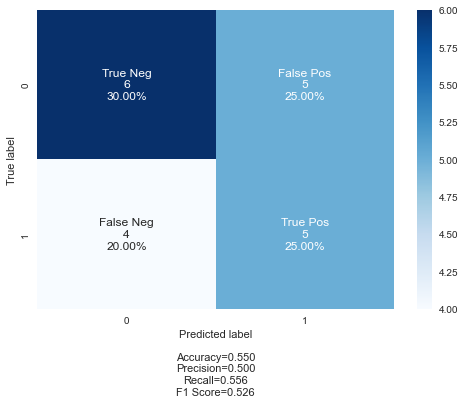

In [77]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [78]:
resultsDF = performanceMetricsDF(metrics, y_train2, y_pred_train, y_test, y_pred_test,"DT")
resultsDF

,Measure,Train_DT,Test_DT
0,ACCURACY,0.75,0.55
1,PRECISION,0.77,0.5
2,RECALL,0.71,0.56
3,F1 SCORE,0.74,0.53
4,AUC,0.75,0.55


/Users/franciscorfafonso/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


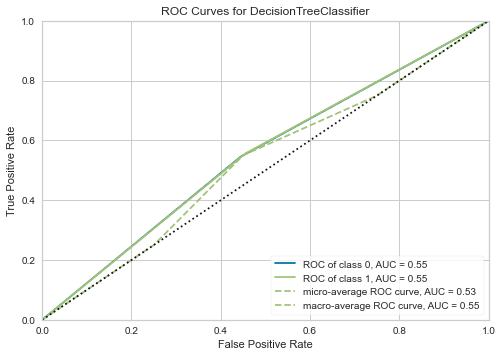

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [79]:
# ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train2, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

In [80]:
# Loading the dataset where we stored the values of the models and checking it
eva = resultsDF_compare
eva.head(6)

,Measure,Train_LR,Test_LR,Train_SVM,Test_SVM,Train_KNN,Test_KNN,Train_NN,Test_NN,Train_NB,Test_NB,Train_DT,Test_DT
0,ACCURACY,0.87,0.8,0.87,0.6,1.0,0.75,0.9,0.75,0.69,0.6,0.75,0.55
1,PRECISION,0.79,0.78,0.8,0.54,1.0,0.7,0.85,0.83,0.62,0.53,0.77,0.5
2,RECALL,1.0,0.78,0.97,0.78,1.0,0.78,0.97,0.56,1.0,1.0,0.71,0.56
3,F1 SCORE,0.88,0.78,0.88,0.64,1.0,0.74,0.9,0.67,0.76,0.69,0.74,0.53
4,AUC,0.87,0.8,0.87,0.62,1.0,0.75,0.9,0.73,0.69,0.64,0.75,0.55


In [81]:
eva.to_pickle('classification_model_evaluation.pkl')
